In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold

from matplotlib import pyplot
import itertools

%matplotlib inline

import random 
  
random.seed(42) 

KNeighborsClassifier(n_neighbors=4)


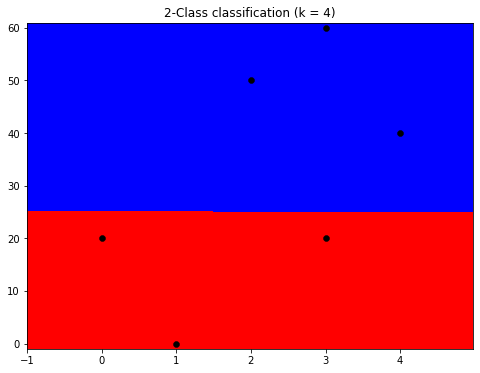

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import datasets
import seaborn as sns
from matplotlib.colors import ListedColormap

# dataset
X = np.array([[0, 20], [2, 50], [3, 60], [3, 20], [4, 40], [1, 0]])
target =  [0, 0, 0, 1, 1, 1]

#plt.scatter(X[:,0], X[:,1], color='red')

# fit a k-nearest neighbor model to the data
K = 4
model = KNeighborsClassifier(n_neighbors = K)
model.fit(X, target)
print(model)


#fig, ax = plt.subplots(1,1, figsize=(10,6))
#ax.plot(X, target, 'o', label = "data")
#xgrid = np.linspace(np.min(X[:,0]), np.max(X[:,1]), 100)


#prediction = model.predict(xgrid.reshape(-1,1))
#ax.plot(xgrid, prediction)


cmap_light = ListedColormap(['blue', 'red'])
cmap_bold = ['darkorange', 'c', 'darkblue']
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(x=X[:, 0], y=X[:, 1],
                palette=cmap_bold, alpha=1.0, edgecolor="black", color="black")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-Class classification (k = %i)"
          % (K))
    
plt.show()

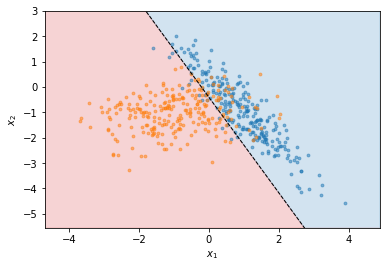

In [3]:
from sklearn.datasets import make_classification


#generate the dataset
X, Y = make_classification(n_features=2, n_samples = 500, n_redundant =0, 
                           n_informative=2, random_state=10, n_clusters_per_class=1)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)

import sklearn as sk
from sklearn.linear_model import LogisticRegression

logit = sk.linear_model.LogisticRegression()
logit.fit(X_train, y_train)
logit.coef_
y_hat = logit.predict(X_test)

# Retrieve the model parameters.
b = logit.intercept_[0]
w1, w2 = logit.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = X[:, 0].min() - 1, X[:, 0].max() + 1
ymin, ymax = X[:, 1].min() - 1, X[:, 1].max() + 1
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:red', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:blue', alpha=0.2)

plt.scatter(*X[Y==0].T, s=8, alpha=0.5)
plt.scatter(*X[Y==1].T, s=8, alpha=0.5)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')

plt.show()


In [4]:
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# this function may help to manually make confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

# Using the logistic model throughout:

# Re-calculating the default confusion matrix
print("confusion matrix (table): \n", confusion_matrix(y_test,t_repredict(logit,0.5,X_test)))

accuracy = accuracy_score(y_test, y_hat)
error_rate = 1 - accuracy
print("\nError rate: ", error_rate)


confusion matrix (table): 
 [[56  4]
 [10 30]]

Error rate:  0.14


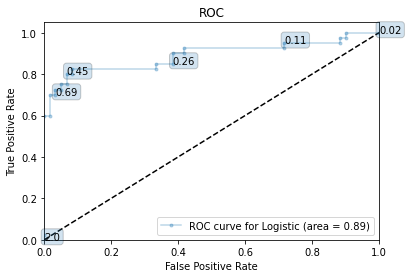

In [14]:
from sklearn.metrics import roc_curve, auc

# a function to make 'pretty' ROC curves for this model
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax


make_roc("Logistic", logit, y_test, X_test, ax=None, labe=5, proba=True, skip=1);